## **Problem**
 Use of Social media has been increasing day by day and also hate Speech is also increasing along with number of users. So it is tough challenge for companies to monitor each and every tweet of users, so we are developing a machine learning model to identify the hate speech tweets automatically which saves lot of resources for companies. In this problem, the data set given has only 25% of hate tweets, so when we build a model usin this data the model performs better on the normal tweets which doesn't solve our problem. So we need to oversample the hate tweets so that the two classes will be equal and our model works better.

In [6]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re


In [1]:
df = pd.read_csv("train_ameer.csv")
df.head()

NameError: name 'pd' is not defined

In [9]:
hate_tweet = df[df.label == 1]
hate_tweet.head()

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...


In [10]:
normal_tweet = df[df.label == 0]
normal_tweet.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


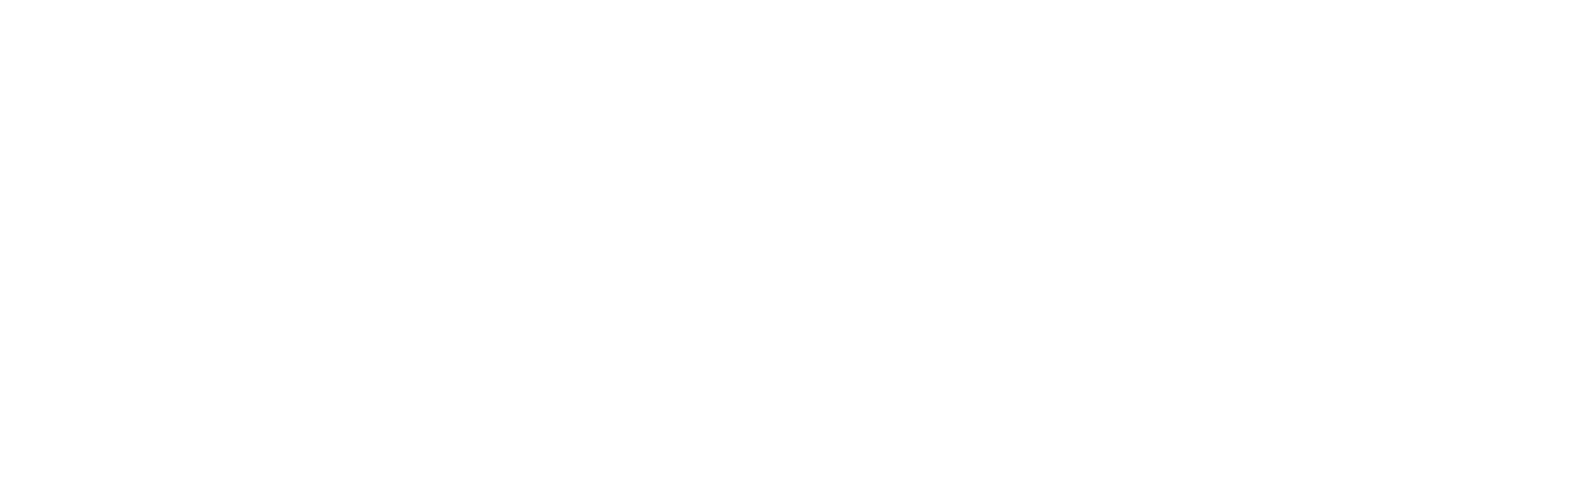

In [59]:
# Hate Word clouds
from os import path
from PIL import Image
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(review for review in hate_tweet.tweet)
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
# plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [12]:
#distributions
df_Stat=df[['label','tweet']].groupby('label').count().reset_index()
df_Stat.columns=['label','count']
df_Stat['percentage']=(df_Stat['count']/df_Stat['count'].sum())*100
df_Stat

,label,count,percentage
0,0,29720,92.98542
1,1,2242,7.01458


In [13]:
def process_tweet(tweet):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

In [14]:
df['processed_tweets'] = df['tweet'].apply(process_tweet)
df.head()

,id,label,tweet,processed_tweets
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can t use cause they ...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in ur
4,5,0,factsguide: society now #motivation,factsguide society now motivation


In [15]:
#As this dataset is highly imbalance we have to balance this by over sampling
cnt_non_fraud = df[df['label'] == 0]['processed_tweets'].count()
df_class_fraud = df[df['label'] == 1]
df_class_nonfraud = df[df['label'] == 0]
df_class_fraud_oversample = df_class_fraud.sample(cnt_non_fraud, replace=True)
df_oversampled = pd.concat([df_class_nonfraud, df_class_fraud_oversample], axis=0)

print('Random over-sampling:')
print(df_oversampled['label'].value_counts())

Random over-sampling:
label
0    29720
1    29720
Name: count, dtype: int64


In [16]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split
X = df_oversampled['processed_tweets']
y = df_oversampled['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = None)

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)

In [18]:
x_train_counts = count_vect.fit_transform(X_train)
x_train_tfidf = transformer.fit_transform(x_train_counts)

In [80]:
import pickle
with open("vectoriser.pkl", 'wb') as file:
    pickle.dump(count_vect, file)
with open("transformer.pkl", 'wb') as file:
    pickle.dump(transformer, file)

In [19]:
print(x_train_counts.shape)
print(x_train_tfidf.shape)

(47552, 34141)
(47552, 34141)


In [20]:
x_test_counts = count_vect.transform(X_test)
x_test_tfidf = transformer.transform(x_test_counts)

In [21]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=500)
model.fit(x_train_tfidf,y_train)

RandomForestClassifier(n_estimators=500)

In [111]:
import pickle
with open("random.pkl", 'wb') as file:
    pickle.dump(model, file)

In [25]:
predictions = model.predict(x_test_tfidf)

In [26]:

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test, predictions))

[[5622  225]
 [   0 6041]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      5847
           1       0.96      1.00      0.98      6041

    accuracy                           0.98     11888
   macro avg       0.98      0.98      0.98     11888
weighted avg       0.98      0.98      0.98     11888



In [29]:
#Building XGBoost Model
from xgboost import XGBClassifier
model_bow = XGBClassifier(random_state=22,learning_rate=0.9)
model_bow.fit(x_train_tfidf,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.9, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=22, ...)

In [30]:
predict_xgb = model_bow.predict(x_test_tfidf)

In [31]:
print(confusion_matrix(y_test,predict_xgb))
print(classification_report(y_test,predict_xgb))

[[5545  302]
 [ 140 5901]]
              precision    recall  f1-score   support

           0       0.98      0.95      0.96      5847
           1       0.95      0.98      0.96      6041

    accuracy                           0.96     11888
   macro avg       0.96      0.96      0.96     11888
weighted avg       0.96      0.96      0.96     11888



In [32]:
#SVM Model
from sklearn import svm
import pickle
lin_clf = svm.LinearSVC()
lin_clf.fit(x_train_tfidf,y_train)


LinearSVC()

In [56]:
import pickle
with open("svm.pkl", 'wb') as file:
    pickle.dump(lin_clf, file)

In [33]:
predict_svm = lin_clf.predict(x_test_tfidf)

In [34]:
from sklearn.metrics import confusion_matrix,f1_score
print(confusion_matrix(y_test,predict_svm))
print(classification_report(y_test, predict_svm))

[[5710  137]
 [  18 6023]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5847
           1       0.98      1.00      0.99      6041

    accuracy                           0.99     11888
   macro avg       0.99      0.99      0.99     11888
weighted avg       0.99      0.99      0.99     11888



In [35]:
#Logistic Regression Model
from sklearn.linear_model import LogisticRegression

In [36]:
logreg = LogisticRegression(random_state=42)

In [37]:
#Building Logistic Regression  Model
logreg.fit(x_train_tfidf,y_train)

LogisticRegression(random_state=42)

In [38]:
predict_log = logreg.predict(x_test_tfidf)

In [39]:
print(confusion_matrix(y_test,predict_log))
print(classification_report(y_test, predict_log))

[[5623  224]
 [  55 5986]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      5847
           1       0.96      0.99      0.98      6041

    accuracy                           0.98     11888
   macro avg       0.98      0.98      0.98     11888
weighted avg       0.98      0.98      0.98     11888



In [40]:
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
NB.fit(x_train_tfidf, y_train)

MultinomialNB()

In [98]:
with open("NB.pkl", 'wb') as file:
    pickle.dump(NB, file)

In [41]:
predict_nb = NB.predict(x_test_tfidf)

In [42]:
print(confusion_matrix(y_test,predict_nb))
print(classification_report(y_test, predict_nb))

[[5403  444]
 [  91 5950]]
              precision    recall  f1-score   support

           0       0.98      0.92      0.95      5847
           1       0.93      0.98      0.96      6041

    accuracy                           0.95     11888
   macro avg       0.96      0.95      0.95     11888
weighted avg       0.96      0.95      0.95     11888



In [43]:
#Test Data Set
df_test = pd.read_csv("test_tweets_ameer.csv")
df_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [44]:
df_test.shape

(17197, 2)

In [45]:
df_test['processed_tweets'] = df_test['tweet'].apply(process_tweet)
df_test.head()

,id,tweet,processed_tweets
0,31963,#studiolife #aislife #requires #passion #dedic...,studiolife aislife requires passion dedication...
1,31964,@user #white #supremacists want everyone to s...,white supremacists want everyone to see the ne...
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe ways to heal your acne altwaystoheal heal...
3,31966,is the hp and the cursed child book up for res...,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",3rd bihday to my amazing hilarious nephew eli ...


In [46]:
X = df_test['processed_tweets']
x_test_counts = count_vect.transform(X)
x_test_tfidf = transformer.transform(x_test_counts)

In [48]:
df_test['predict_nb'] = NB.predict(x_test_tfidf)
df_test[df_test['predict_nb']==1].head(100)

,id,tweet,processed_tweets,predict_nb
19,31982,thought factory: bbc neutrality on right wing ...,thought factory bbc neutrality on right wing f...,1
26,31989,chick gets fucked hottest naked lady,chick gets fucked hottest naked lady,1
30,31993,i'll #never be #120 #again i'm #i'm a #thick...,i ll never be 120 again i m i m a thick women ...,1
33,31996,suppo the #taiji fisherman! no bullying! no ra...,suppo the taiji fisherman no bullying no racis...,1
34,31997,i say we because i'm speaking collectively. i'...,i say we because i m speaking collectively i v...,1
...,...,...,...,...
754,32717,â¦ you #hispanic &amp; feel like the are sto...,you hispanic amp feel like the are stomping on...,1
775,32738,#juststandup #free #justshare #can'tsmilewit...,juststandup free justshare can tsmilewithoutyo...,1
785,32748,"@user town of ""whiteland"" fights for its nativ...",town of whiteland fights for its native americ...,1
786,32749,@user while #racialprejudice is real has exis...,while racialprejudice is real has existed acro...,1


In [49]:

df_test['predict_svm'] = NB.predict(x_test_tfidf)
df_test['predict_rf'] = model.predict(x_test_tfidf)
df_test.head()

,id,tweet,processed_tweets,predict_nb,predict_svm,predict_rf
0,31963,#studiolife #aislife #requires #passion #dedic...,studiolife aislife requires passion dedication...,0,0,1
1,31964,@user #white #supremacists want everyone to s...,white supremacists want everyone to see the ne...,0,0,1
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe ways to heal your acne altwaystoheal heal...,0,0,0
3,31966,is the hp and the cursed child book up for res...,is the hp and the cursed child book up for res...,0,0,0
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",3rd bihday to my amazing hilarious nephew eli ...,0,0,0


In [50]:

file_name = 'test_predictions_Twitter Hate Analysis.csv'
df_test.to_csv(file_name,index=False)


In [ ]:
# **Results**

#Algorithms                                  F1-Score

#SVM                                            99%

#Random Forest                                  98%

#XG Boost                                       91%

#Navie Bayes                                    95%

#Logistic Regression                            98%
 


In [114]:
with open("vectoriser.pkl", 'rb') as file:
    vect = pickle.load(file)
with open("NB.pkl", 'rb') as file:
    NBC = pickle.load(file)
with open("transformer.pkl", 'rb') as file:
    Trans = pickle.load(file)

def process_tweet(tweet):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",tweet.lower()).split())

def prediction_tweet(tweet):
    tweet_to_check = pd.DataFrame({"processed_tweets":tweet},index=[1])
    tweet_to_check["processed_tweets"] = tweet_to_check["processed_tweets"].apply(process_tweet)
    X = tweet_to_check['processed_tweets']
    x_test_counts = count_vect.transform(X)
    x_test_tfidf = transformer.transform(x_test_counts)
    prediction = model.predict(x_test_tfidf)
    if prediction == [0]:
        return "Not a hate speech"
    else:
        return "Hate Speech"
    

prediction_tweet("You are good")

'Not a hate speech'